In [1]:
import os
import PIL
# Provides high level file operation
import shutil
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import requests

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader

Downlaoding and extracting data

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
tgz_path  = "data.tgz"

response = requests.get(url=dataset_url, stream=True)
with open(tgz_path , "wb") as f:
    f.write(response.content)

unzip_dir = "flowers"  # Specify the directory where the zip content will be extracted
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=unzip_dir)

os.remove(tgz_path)

In [4]:
data_dir = pathlib.Path(unzip_dir+'/flower_photos')
print("Directory = ",data_dir)
# Counting total number of images
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

Directory =  flowers/flower_photos


3670

In [5]:
# Hyperparameters
batch_size = 32
img_height = 180
img_width = 180

In [6]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

### Loading data

In [7]:
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

In [8]:
class_names = dataset.classes
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Splitting data into train and valid

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train, val = random_split(dataset=dataset, lengths=[train_size, val_size])

In [10]:
print(f"Training set length = {len(train)}")
print(f"Validation set length = {len(val)}")

Training set length = 2936
Validation set length = 734


### Dataloaders

In [11]:
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True)

Viewing data

torch.Size([32, 3, 180, 180]) torch.Size([32])


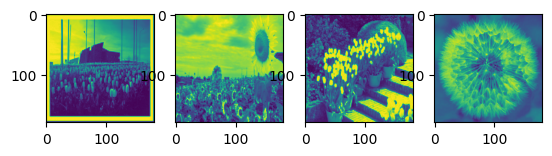

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape, labels.shape)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i][0])
plt.show()

Viewing 10 images

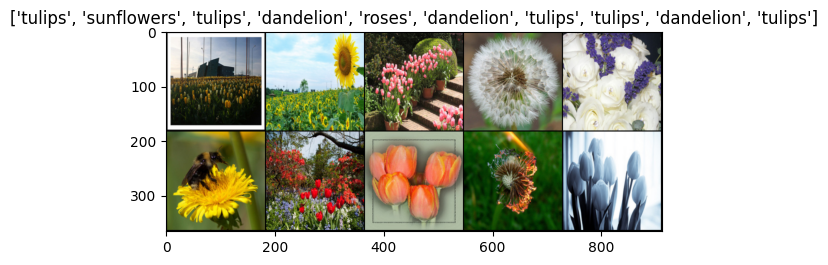

In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    # De-Normalizing
    inp*=255
    # PyTorch stores image data in the format (channels, height, width), 
    # while matplotlib, which is used for displaying images, expects image data in the format (height, width, channels).
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

n_images = 10
images = images[:n_images]
labels = labels[:n_images]
out = torchvision.utils.make_grid(images, nrow=5)

imshow(out, title=[class_names[x] for x in labels[:n_images]])

### CNN Model

In [14]:
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()

#         self.conv_layer = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#             )
#         self.flatten = nn.Flatten()

#         self.fc_layer = nn.Sequential(
#              nn.Linear(in_features=self._get_conv_output_shape(), out_features=128),
#              nn.ReLU(),
#              nn.Linear(in_features=128, out_features=64),
#              nn.Linear(in_features=64, out_features=5)
#             )

#     def forward(self, x):
#         x = self.conv_layer(x)
#         x = self.flatten(x)
#         x = self.fc_layer(x)
#         return x

#     def _get_conv_output_shape(self):
#         # Dummy input
#         dummy_input = torch.randn(1, 3, img_height, img_width)  # Assuming input images are 32x32 with 3 channels
#         conv_output = self.conv_layer(dummy_input)
#         return conv_output.numel()  # Total number of features after flattening


In [15]:
num_batches = len(train_loader)
print(num_batches)

92


In [16]:
# device = torch.device(device='cuda') if torch.cuda.is_available() else torch.device(device='cpu')
# print(f"{device} is available")

# model = Model().to(device)

# # Optimizer
# learning_rate = 0.001
# optimizer = torch.optim.Adam(params=model.parameters(), lr= learning_rate)

# # Error
# criterion = nn.CrossEntropyLoss()

# num_epochs = 50

# for epoch in range(1, num_epochs+1):
#     acc, total_loss, size = 0, 0, 0
#     for batch, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)

#         # Fwd Propagation
#         predicted = model(images)

#         loss = criterion(predicted, labels)

#         # backward propagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         max_value, indexes = torch.max(input=predicted, dim=1)
#         correct_labels = (labels==indexes).sum().item()
#         acc += correct_labels

#         size+=labels.shape[0]

#     avg_loss = total_loss/size
#     avg_acc = acc/size
#     if (epoch)%10==0:
#         print(f"Epoch {epoch}/{num_epochs}, Loss = {avg_loss:.4f}, Acc = {avg_acc:4f}")


### Using Transfer Learning

In [17]:
import copy

def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss, train_correct, train_total = 0, 0, 0

        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate validation loss and accuracy
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)

        # Saving best accuracy
        if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    model.load_state_dict(best_model_wts)
    return model

In [20]:
device = torch.device(device='cuda') if torch.cuda.is_available() else torch.device(device='cpu')
num_epochs = 50

model = models.resnet18(pretrained=True)
# Freeze all the layers
for param in model.parameters():
    param.requires_grad=False

# Number of input features for fully connected layers
num_ftrs = model.fc.in_features

# Defining own FC layer where input_dim will the same and output dim will be 2 instead of 1000.
model.fc = nn.Linear(num_ftrs, 5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/50], Train Loss: 0.7499, Train Acc: 73.81%, Val Loss: 1.0949, Val Acc: 60.49%
Epoch [2/50], Train Loss: 0.5310, Train Acc: 82.29%, Val Loss: 0.4643, Val Acc: 83.65%
Epoch [3/50], Train Loss: 0.4866, Train Acc: 84.37%, Val Loss: 0.3743, Val Acc: 86.10%
Epoch [4/50], Train Loss: 0.4225, Train Acc: 85.42%, Val Loss: 0.4922, Val Acc: 84.88%
Epoch [5/50], Train Loss: 0.3945, Train Acc: 86.85%, Val Loss: 0.7772, Val Acc: 77.93%
Epoch [6/50], Train Loss: 0.4503, Train Acc: 85.15%, Val Loss: 0.4215, Val Acc: 86.92%
Epoch [7/50], Train Loss: 0.4280, Train Acc: 86.24%, Val Loss: 0.5097, Val Acc: 85.29%
Epoch [8/50], Train Loss: 0.3453, Train Acc: 88.45%, Val Loss: 0.6988, Val Acc: 80.93%
Epoch [9/50], Train Loss: 0.4016, Train Acc: 87.87%, Val Loss: 0.7012, Val Acc: 80.38%
Epoch [10/50], Train Loss: 0.4863, Train Acc: 85.52%, Val Loss: 0.5414, Val Acc: 84.60%
Epoch [11/50], Train Loss: 0.3559, Train Acc: 87.94%, Val Loss: 0.4703, Val Acc: 86.51%
Epoch [12/50], Train Loss: 0.3391, Train 

In [21]:
torch.save(model.state_dict(), 'best_model_weights.pth')
torch.save(model, 'best_model.pth')

# # Loading the model later
# # Initialize the model again
# loaded_model = MyModel().to(device)
# loaded_model.load_state_dict(torch.load('best_model.pth'))
# loaded_model.eval()  # Set the model to evaluation mode